In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import the libraries as shown below
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import math
import shutil


In [3]:
#count the number of images in the respective classes 1-Sick, and 0- Normal
ROOT_DIR='/content/drive/MyDrive/deep_learning_project/dataset2'
number_of_images ={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] =len( os.listdir(os.path.join(ROOT_DIR, dir)))

  


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
number_of_images.items()

dict_items([('images', 224)])

In [6]:
os.listdir("/content/drive/MyDrive/deep_learning_project/dataset2")

['images']

In [7]:
#split the data for training and testing and validation 70:15:15

In [8]:
#create a training folder
def dataFolder(p, split):
  # we create a training folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size=(math.floor(split*number_of_images[dir])-5),
                                  replace=False):
        O=os.path.join(ROOT_DIR,dir,img)#path
        D=os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
      else:
        print(f"{p} Folder exists")
      
      
      

In [9]:
dataFolder("train", 0.7)


train Folder exists


In [10]:
dataFolder("test",0.15)


test Folder exists


In [11]:
dataFolder("val",0.15)

val Folder exists


In [12]:
#preparing data generator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet,preprocess_input

In [13]:
#preparing our data using Data Generator
def preprocessingImages1(path):
  """
  input : path
  output : pre processed images
  """
  image_data=ImageDataGenerator(zoom_range=0.2, shear_range=0.2, 
                                preprocessing_function=preprocess_input, horizontal_flip=True,) # data augmentation
  image=image_data.flow_from_directory(directory =path, target_size=(224,224),
                                       batch_size=8, class_mode='binary')

  return image

In [14]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 151 images belonging to 1 classes.


In [15]:
train_data.class_indices

{'images': 0}

In [16]:
def preprocessingImages2(path):
  """
  input : path
  output : pre processed images
  """
  image_data=ImageDataGenerator( preprocessing_function=preprocess_input)
  image=image_data.flow_from_directory(directory =path, target_size=(224,224), batch_size=8, class_mode='binary')

  return image

In [17]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 28 images belonging to 1 classes.


In [18]:
path="/content/val"
val_data=preprocessingImages2(path)

Found 28 images belonging to 1 classes.


In [19]:
#Model training with a pre-trained model
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet,preprocess_input
import keras
from sklearn.metrics import precision_score, recall_score


In [20]:
#create a model
base_model=MobileNet(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [21]:
#Not to train a model again
for layer in base_model.layers:
  layer.trainable=False

In [22]:
#How the base_model looks like
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [23]:
X=Flatten()(base_model.output)
X=Dense(units=1, activation='sigmoid')(X)

#final model
model= Model(base_model.input, X)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [25]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy,
 metrics=['accuracy'])

In [26]:
# Early stopping and checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Early stopping
es = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=3,
                   verbose=1)

# Model checkpoint
mc = ModelCheckpoint(monitor="accuracy",filepath="bestmodel.h5", 
                     verbose=1, save_best_only=True) 



cb= [es,mc]

In [27]:
#train data
hist=model.fit_generator(train_data, 
                         steps_per_epoch=8,
                         epochs=10,
                         verbose=1,
                         validation_data=val_data,
                         validation_steps=16,
                         callbacks=cb)

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9365WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 16 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: accuracy improved from -inf to 0.93651, saving model to bestmodel.h5
8/8 [==============================] - 9s 866ms/step - loss: 0.1626 - accuracy: 0.9365 - val_loss: 8.6328e-28 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 9.0975e-15 - accuracy: 1.0000
Epoch 00002: accuracy improved from 0.93651 to 1.00000, saving model to bestmodel.h5
8/8 [==============================] - 3s 417ms/step - loss: 9.0975e-15 - accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 9.8924e-36 - accuracy: 1.0000
Epoch 00003: accuracy did not improve from 1.00000
8/8 [===

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#load the best fit model
model=load_model("/content/bestmodel.h5")

In [35]:
#model accuracy
acc=model.evaluate_generator(test_data)[1]
print(f"The model accuracy is {acc*100}%")

The model accuracy is 100.0%


In [36]:
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

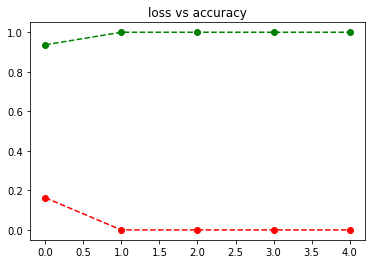

In [37]:
plt.plot(h['accuracy'], 'go--')
plt.plot(h['loss'], 'go--',c="red")
plt.title("loss vs accuracy")
plt.show()

In [38]:
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

In [39]:
import cv2
import numpy as np
img=cv2.imread("/content/drive/MyDrive/deep_learning_project/dataset2/images/sick_eff24.png")
img=cv2.resize(img,(224,224))
img.shape
img=np.array(img)
img=img.reshape(1,224,224,3)
image=preprocess_input(img)

img=np.expand_dims(img, axis=0)
pred=model.predict(image)
print(pred)

[[0.]]


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
y_pred=model.predict(test_data)
pred=[np.argmax(element) for element in y_pred]

print("classification report: \n", classification_report(pred,pred))



classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28

